In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os
from scipy.interpolate import interp1d
from scipy.signal import butter,filtfilt
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import odr

%run python_master.py
%matplotlib qt

# Imort frequency files

In [34]:
folder = "C:\\Users\\Florian\\Box Sync\\Projects"
project = "\\Mn3Ge\\RUS\\Mn3Ge_2001B\\temp_dependent_data_with_Labview\\improved_setup\\new_data"
# project = '\\Mn3.019Sn0.981\\RUS\\2007A\\080720'
project = '\\UTe2\\RUS\\UTe2_2007C\\PLL\\201105'
project = '\\UTe2\\RUS\\UTe2_2007C\\Red Pitaya\\201111\\monitor_1'

data_files = os.listdir(folder+project)
data_files = [i for i in data_files if i[-4:]=='.dat']
filenames = [folder + project + '\\' + i for i in data_files[:]]
data_files

['2326_mo.dat', '2340_mo.dat', '2372_mo.dat', '2421_mo.dat']

In [61]:
i = 3
filename = filenames[i]
data = data_extract(filename)
T = data.import_data(1,3)[0]
f = data.import_data(1,3)[1]
g = data.import_data(1,3)[2]

f = f[np.argsort(T)]
T = np.sort(T)

Tnew = []
fnew = []
gnew = []
for i in np.arange(len(T)): 
    if T[i] not in Tnew: 
        Tnew.append(T[i])
        fnew.append(f[i])
        gnew.append(g[i])
T = np.array(Tnew)
f = np.array(fnew) 
f = f[np.argsort(T)]
g = np.array(gnew)
g = g[np.argsort(T)]
T = np.sort(T)


# filename1 = filenames[i+1]
# data1 = data_extract(filename1)
# T1 = data1.import_data(1,2)[0]
# f1 = data1.import_data(1,2)[1]
# f1 = f1[np.argsort(T1)]
# T1 = np.sort(T1)


# filename2 = filenames[i+2]
# data2 = data_extract(filename2)
# T2 = data2.import_data(1,2)[0]
# f2 = data2.import_data(1,2)[1]
# f2 = f2[np.argsort(T2)]
# T2 = np.sort(T2)


# filename3 = filenames[i+3]
# data3 = data_extract(filename3)
# T3 = data3.import_data(1,2)[0]
# f3 = data3.import_data(1,2)[1]
# f3 = f3[np.argsort(T3)]
# T3 = np.sort(T3)

# filename4 = filenames[i+4]
# data4 = data_extract(filename4)
# T4 = data4.import_data(1,2)[0]
# f4 = data4.import_data(1,2)[1]
# f4 = f4[np.argsort(T4)]
# T4 = np.sort(T4)



def different_offsets (p, T):
    a, b, c = p
    t1 = T[T<Tc]
    f1 = a*t1 + b
    t2 = T[T>=Tc]
    f2 = a*t2 + c
    ftotal = np.append(f1, f2)
    return ftotal

def fct (p, T):
    a = 0
    for i in np.arange(len(p)):
        a = a + p[i] * np.ones(len(T)) * T**i
    return a

In [62]:
plt.figure(figsize=(12,8))
plt.scatter(T, f, s=13)
# plt.scatter(T1, f1-f1[0]+f2[0], s=13)
# plt.scatter(T2, f2, s=13)
# plt.scatter(T3, f3, s=13)
# plt.scatter(T4, f4-f4[0]+f2[0], s=13)

plt.figure(figsize=(12,8))
plt.scatter(T, g, s=13)

In [6]:
T1 = 400
T2 = 398.5
mask = (T<T1) | (T>T2)

Tint = np.linspace(min(T), max(T), len(T))
fint = interp1d(T[mask], f[mask], kind='cubic')(Tint)

plt.figure(figsize=(12,8))
plt.plot(Tint, fint, c='tab:orange', zorder=-1)
plt.scatter(T, f, s=1)

In [392]:
# f = interp1d(T[mask], f[mask], kind='cubic')(Tint)
# T = Tint
# plt.scatter(T, f, s=1)

In [370]:
# T1 = 400
# T2 = 398.5
# mask = (T<T1) | (T>T2)

# t, c, k = interpolate.splrep(T[mask], f[mask], s=0, k=4)
# xx = np.linspace(min(T), max(T), len(T))
# spline = interpolate.BSpline(t, c, k, extrapolate=False)

# plt.figure(figsize=(12,8))
# plt.plot(T, f, 'bo', label='Original points')
# plt.plot(xx, spline(xx), 'r', label='BSpline')

# adjust for jumps

[&lt;matplotlib.lines.Line2D at 0x2869ee4f2b0&gt;]

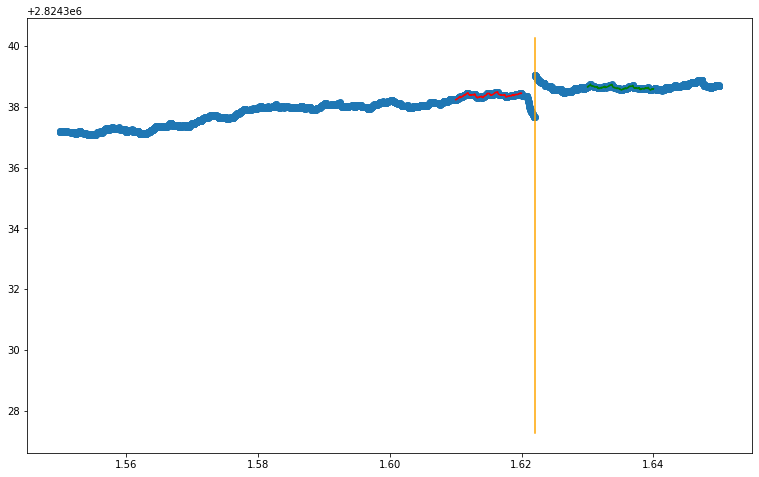

In [17]:
plt.figure(figsize=(13,8))
Tmin = 1.55
Tmax = 1.65

mask = (T > Tmin) & (T < Tmax)
plt.scatter(T[mask],f[mask])

T1 = 1.61
T2 = 1.62
T3 = 1.63
T4 = 1.64

mask1 = ((T>T1) & (T<T2))
mask2 = ((T>T3) & (T<T4))
maskfit = mask1 | mask2
plt.plot( T[mask1], f[mask1], c='red')
plt.plot( T[mask2], f[mask2], c='green')

Tc = 1.622

#plt.plot([Tc, Tc], [np.mean(f)-1, np.mean(f)+1], c='orange')
plt.plot([Tc, Tc], [np.mean(f)+5, np.mean(f)+18], c='orange')

[&lt;matplotlib.lines.Line2D at 0x2869eeb2828&gt;]

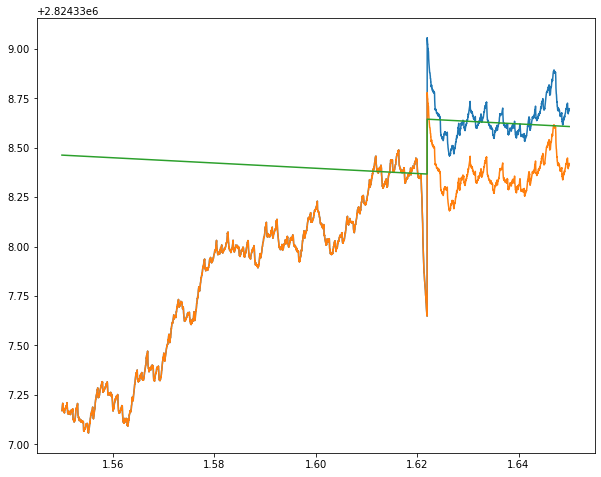

In [18]:
data = odr.RealData(T[maskfit], f[maskfit])
initial_guess = [0,0,0]
fix = [1,1,1]
model = odr.Model(different_offsets)
fit = odr.ODR(data, model, beta0=initial_guess)#, ifixb=fix)
out = fit.run()
popt = out.beta

fnew = np.append(f[T<Tc], f[T>=Tc] + popt[1] - popt[2])

plt.figure(figsize=(10,8))
#plt.plot(T, fnew)
plt.plot(T[mask], f[mask])
plt.plot(T[mask], fnew[mask])
plt.plot(T[mask], different_offsets(popt, T[mask]))

In [19]:
f = fnew

[&lt;matplotlib.lines.Line2D at 0x2869ef20908&gt;]

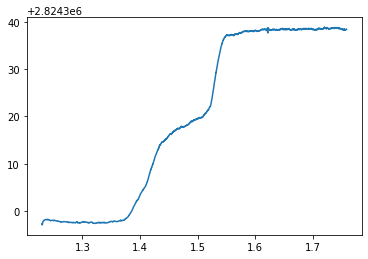

In [20]:
plt.plot(T, f)

# clean data a little bit

In [88]:
import pandas as pd

threshold = 3
fmedian = pd.DataFrame(f).rolling(window=3, center=True).median().fillna(method='bfill').fillna(method='ffill').to_numpy().flatten()

difference = np.abs(f - fmedian)
outlier_idx = difference > threshold

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(T, f)
ax.scatter(T[outlier_idx], f[outlier_idx])

In [91]:
np.invert(outlier_idx)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [64]:
Tcl1 = 1.2
Tcl2 = 3
# Tcl1 = 377
# Tcl2 = 387
clean_mask = (T>Tcl1) & (T<Tcl2)

fclean = f[clean_mask]
Tclean = T[clean_mask]
gclean = g[clean_mask]
data_clean = odr.RealData(Tclean, fclean)
initial_guess_clean = [0,0]
fix_clean = [1,1,1,0,0]
model_clean = odr.Model(fct)
fit_clean = odr.ODR(data_clean, model_clean, beta0=initial_guess_clean)#, ifixb=fix_clean)
out_clean = fit_clean.run()
popt_clean = out_clean.beta


epsilon = 10
index = abs(fclean - fct(popt_clean, Tclean)) < epsilon

plt.figure(figsize=(12,7))
plt.plot(Tclean, fct(popt_clean, Tclean))
plt.plot(T, f)
plt.plot(Tclean[index], fclean[index])
plt.xlim(Tcl1, Tcl2)
# plt.ylim(920+2.662e6, 930+2.662e6)
print ( len(index) - sum(np.ones(len(index))[index]),  sum(np.ones(len(index))[index]))

210.0 46.0


In [52]:
fnew = np.append(f[np.invert(clean_mask)], fclean[index])
gnew = np.append(g[np.invert(clean_mask)], gclean[index])
Tnew = np.append(T[np.invert(clean_mask)], Tclean[index])
fnew = fnew[np.argsort(Tnew)]
gnew = gnew[np.argsort(Tnew)]
Tnew = np.sort(Tnew)

plt.figure(figsize=(12,7))
plt.scatter(Tnew, fnew, s=0.05, c='tab:blue')

plt.figure(figsize=(12,7))
plt.scatter(Tnew, gnew, s=0.05, c='tab:blue')

In [53]:
f = fnew
g = gnew
T = Tnew

# Running average

In [360]:
Tmin = 1.2
Tmax = 2.5
Tmin = 353
Tmax = 365
N = 10

maskave = (T > Tmin) & (T < Tmax)
fmaskave = f[maskave]
fra_input = np.append( np.append(np.ones(N)*fmaskave[0], fmaskave) , np.ones(N)*fmaskave[-1] )
frunning_sum = np.zeros(len(fmaskave))

for i in np.arange(2*N):
    frunning_sum = frunning_sum + fra_input[i:-2*N+i]

fra = frunning_sum / (2*N)

# fnew = np.append(f[np.invert(maskave)], fra)
fnew = np.append(fra, f[np.invert(maskave)])

In [361]:
plt.figure(figsize=(12,8))
plt.scatter(T, f, s=1)
plt.scatter(T, fnew, s=1)

In [362]:
f = fnew


# save data

In [54]:
save_filename = filename[:-4] + '_clean.dat'

if os.path.isfile(save_filename) == True:
    x='w'
else:
    x='x'

with open(save_filename, x) as clean:
    clean.write('T (K)\tf (kHz)\twidth (kHz)\n ')
    for i in np.arange(len(f)-1):
        clean.write(str(T[i]) + '\t' + str(f[i]) + '\t' + str(g[i]) + '\n')